# Week 5 – Recurrent Neural Networks

In [1]:
import tensorflow 
import tensorflow.keras as keras
import numpy as np

In [2]:
from IPython.display import Image

## Outline


- Recurrent Neurons 
- Basic RNNs in TensorFlow 
- Training RNNs 
- Deep RNNs 
- LSTM Cell 
- GRU Cell 

    
## Learning Outcomes

- Understanding of fundamental concepts underlying RNNs
- Main problems RNNs face and solutions to fight them
- Comprenhension of the different types of cells: LSTMs and GRUs. 
- Familiarity with the implementation of RNNs using TensorFlow and Keras. 
- Exposure to applications where RNNs have shown remarkable performance
- Grasp of practical considerations: training time, parameters, vanishing/exploding gradients,
- Become familiar with the typical architectures
- Practical training and deployment considerations

## Introduction

- Today, we are going to discuss recurrent neural networks (RNN):
    - A class of nets that can predict the future :)
- They can analyze time series data such as stock prices, 
- In autonomous driving systems, they can anticipate car trajectories,
- They can work on sequences of arbitrary lengths,
- They can take sentences, documents, or audio samples as input, making them extremely useful for natural language processing (NLP) systems.
- RNNs can generate sentences, image captions, and much more. 
- We could ask RNNs to predict which are the most likely next notes in a melody, then randomly pick one of these notes and play it. Then ask the net for the next most likely notes, play it, and repeat the process again and again. (Melody composition) see the Magenta project by Google.


We will look at the fundamental concepts underlying RNNs, problem and solutions during training.

## Setup

First, let's make sure this notebook has all the required libraries, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [3]:
import warnings
warnings.filterwarnings("ignore")
#File containing all definitions and utility functions.
from tensorflow import keras
%matplotlib inline
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

#Import tensorflow
import tensorflow as tf
from tensorflow import keras

# Common imports
import numpy as np
import os

# To plot pretty figures
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")



# Recurrent Neurons

- A recurrent neural network looks very much like a feedforward neural network, except it also has connections pointing backwards. 

- Let’s look at the simplest possible RNN, one cell with feedback: 
    - At each time step t, this recurrent neuron receives the inputs $x(t)$ as well as its own output from the previous time step, $y(t–1)$. 
    - We can represent this tiny network against the time axis. This is called unrolling the network through time.


<center><img src="https://drive.google.com/uc?id=1APTz3hmUynG8GJspgaKnjh_4tZfaUzsd" ></center>



Now, to create a layer:
- Every neuron receives both the input vector $x(t)$ and the output vector from the previous time step $y(t–1)$. 
- Note that both the inputs and outputs are vectors now 

<center><img src="https://drive.google.com/uc?id=1IAWzmhjpz8IM9xKmKmbdMmtGFCALOGxL" ></center>

Each recurrent neuron has two sets of weights: 
- for the inputs $x(t)$: $w_x$
- for the outputs of the previous time step, $y(t–1)$: $w_y$
- We can place all the weight vectors for all neurons in two weight matrices, $W_x$ and $W_y$. 
- The output vector of the whole recurrent layer can then be computed as:  
($b$ is the bias vector and $\phi(.)$ is the activation function).


$$
\mathbf{y}_{(t)}=\phi\left(\mathbf{W}_{x}{ }^{T} \mathbf{x}_{(t)}+\mathbf{W}_{y}{ }^{T} \mathbf{y}_{(t-1)}+\mathbf{b}\right)
$$

We can compute a recurrent layer’s output in one shot for a whole mini-batch :


$$
\begin{aligned} \mathbf{Y}_{(t)} &=\phi\left(\mathbf{X}_{(t)} \mathbf{W}_{x}+\mathbf{Y}_{(t-1)} \mathbf{W}_{y}+\mathbf{b}\right) \\ &=\phi\left(\left[\begin{array}{ll}\mathbf{X}_{(t)} & \mathbf{Y}_{(t-1)}\end{array}\right] \mathbf{W}+\mathbf{b}\right) \text { with } \mathbf{W}=\left[\begin{array}{l}\mathbf{W}_{x} \\ \mathbf{W}_{y}\end{array}\right] \end{aligned}
$$

- $Y(t)$ is an $m \times n_{neurons}$ matrix containing the layer’s outputs at time step $t$ for each instance in the mini-batch (m is the number of instances in the mini-batch).

- $X(t)$ is an $m \times n_{inputs}$ matrix containing the inputs for all instances 

- $W_x$ is an $n_{inputs} \times n_{neurons}$ matrix containing the connection weights of the current step.

- $W_y$ is an $n_{neurons} × n_{neurons}$ matrix containing the connection weights for the outputs of the previous time step.

- $b$ is a vector of size $n_{neurons}$ containing each neuron’s bias term.

The weight matrices $W_x$ and $W_y$ are often concatenated vertically into a single weight matrix $W$

The notation $[X(t) Y(t–1)]$ represents the horizontal concatenation of the matrices $X(t)$ and $Y(t–1)$.

Notice that Y(t) is a function of X(t) and Y(t–1), which is a function of X(t–1) and Y(t–2), which is a function of X(t–2) and Y(t–3), and so on. 



# Memory Cells

- The output of a recurrent neuron at time $t$ is a function of all the inputs from previous times:
    - You could say it has a form of memory. 
    
    
- A single recurrent neuron, is a very form of memory cell.

- In general, a cell’s state $h(t)$ is a function of some inputs $x(t)$ and its state at the previous time step: 
    - $h(t) = f(h(t–1), x(t))$
    
    
- The network's output $y(t)$, is also a function of the previous $y(t-1)$ and $x(t)$. 

- We will look at more complex memory cells later today

<center><img src="https://drive.google.com/uc?id=1p1KtbVG3rxs1jL15ZJIkHlX8mkdPLzRM" ></center>


# Input and Output Sequences

- An RNN can simultaneously take a sequence of inputs and produce a sequence of outputs:
    - Useful for predicting time series


- RNNs can also take a sequence of inputs, and ignore all outputs except for the last one:
    - Sequence-to-vector network. i.e. feed the network a sequence of words corresponding to a movie review, and the network would output a sentiment score (e.g., from –1 [hate] to +1 [love]).


- Single input at the first time step (and zeros for all other time steps), and let it output a sequence 
    - Vector-to-sequence network. i.e. the input could be an image, and the output could be a caption for that image.


- Sequence-to-vector network (encoder), followed by a vector-to-sequence network (decoder).  
    - translating a sentence from one language to another. This two-step model, called an Encoder–Decoder. 
    - This model works better because the last words of a sentence can affect the first words of the translation.


<center><img src="https://drive.google.com/uc?id=1ut-l3DRwhvds8WtqcNQw2DcnBtcX6wFx" ></center>





Below you can see the computational graph to compute the training loss of a recurrent network

<center><img src="https://drive.google.com/uc?id=1cwiS24E1J6HKVh7rTU7IX7KB0RaXhoNN" ></center>

$$
\begin{array}{l}{\boldsymbol{a}^{(t)}=\boldsymbol{b}+\boldsymbol{W} \boldsymbol{h}^{(t-1)}+\boldsymbol{U} \boldsymbol{x}^{(t)}} \\ {\boldsymbol{h}^{(t)}=\tanh \left(\boldsymbol{a}^{(t)}\right)} \\ {\boldsymbol{o}^{(t)}=\boldsymbol{c}+\boldsymbol{V} \boldsymbol{h}^{(t)}} \\ {\hat{\boldsymbol{y}}^{(t)}=\operatorname{softmax}\left(\boldsymbol{o}^{(t)}\right)}\end{array}
$$

Following is another RNN whose only recurrence is the feedback connection from the output to the hidden layer
<center><img src="https://drive.google.com/uc?id=1fA8SalfBnRwPmEz7tI6DfXIwvGrCxqC2" ></center>

### Teacher Forcing and Networks with Output Recurrence
<center><img src="https://drive.google.com/uc?id=11RVNyTbbIsX7WIg_Xt_ZXijBPJdWQPIV" ></center>

### Time-unfolded recurrent neural network with a single output
<center><img src="https://drive.google.com/uc?id=1oZKbBMwYID6Zr5EUOjqeNgDccV2gG0b3" ></center>


### Bidirectional RNNs

<center><img src="https://drive.google.com/uc?id=1aMhWHHOlYP74vcejp5RGC-aqSY5lcWLl" ></center>

$$
\begin{array}{l}{\bar{h}_{t}^{(f)}=\tanh \left(W_{x h}^{(f)} \bar{x}_{t}+W_{h h}^{(f)} \bar{h}_{t-1}^{(f)}\right)} \\ {\bar{g}_{t}^{(b)}=\tanh \left(W_{x g}^{(b)} \bar{x}_{t}+W_{g g}^{(b)} \bar{g}_{t+1}^{(b)}\right)} \\ {\bar{o}_{t}=W_{h y}^{(f)} \bar{h}_{t}^{(f)}+W_{g y}^{(b)} \bar{g}_{t}^{(b)}}\end{array}
$$

### Modeling Sequences Conditioned on Context 

An RNN that maps a ﬁxed-length vector $x$ into a distribution over sequences $Y$. 

<center><img src="https://drive.google.com/uc?id=1n6Rikao4cgIgh6ogFMtRN_CfvE_5b95X" ></center>


A conditional recurrent neural network mapping a variable-length sequence of $x$ values into a distribution over sequences of $y$ values of the same length.

<center><img src="https://drive.google.com/uc?id=1_YZwZyca0B6negcRT7glwi6UbLINSwS-" ></center>

### Encoder-Decoder Sequence-to-Sequence Architecture

<center><img src="https://drive.google.com/uc?id=1k87zptKYoNpDoNmWzb5Q3enUEMeV75D6" ></center>

# Training RNNs

The approach is to unroll the RNN through time and then use regular backpropagation  --backpropagation through time (BPTT).




<center><img src="https://drive.google.com/uc?id=1ixYssb7qufxQ_0Tw95haM-wVEbs645rh" ></center>

- There is a first forward pass through the unrolled network ; 
- then the output sequence is evaluated using a cost function 
- and the gradients of that cost function are propagated backward through the unrolled network 
- finally the model parameters are updated using the gradients computed during BPTT. 

Note that the gradients flow backward through all the outputs used by the cost function, not just through the final output. 

Since the same parameters W and b are used at each time step, backpropagation will do the right thing and sum over all time steps.



# Forecasting a Time Series


## Generate the Dataset

In [4]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [5]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [6]:
# series[1:40]

In [7]:
X_train.shape, y_train[0].shape


((7000, 50, 1), (1,))

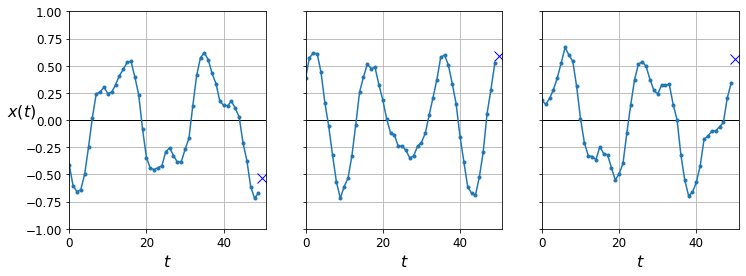

In [8]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
plt.show()

In [9]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1]),
])


optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=2,
                    validation_data=(X_valid, y_valid))

Epoch 1/2
219/219 [==============================] - 11s 34ms/step - loss: 0.1746 - val_loss: 0.0437
Epoch 2/2
219/219 [==============================] - 7s 31ms/step - loss: 0.0401 - val_loss: 0.0274


In [10]:
model.weights

[<tf.Variable 'simple_rnn/simple_rnn_cell/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[0.7853095]], dtype=float32)>,
 <tf.Variable 'simple_rnn/simple_rnn_cell/recurrent_kernel:0' shape=(1, 1) dtype=float32, numpy=array([[0.20730714]], dtype=float32)>,
 <tf.Variable 'simple_rnn/simple_rnn_cell/bias:0' shape=(1,) dtype=float32, numpy=array([0.01509596], dtype=float32)>]

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.predict(np.array([[[0.1],[0.22],[0.4],[0.5],[0.5],[0.42974597],[0.3838964]]]))


array([[0.38317314]], dtype=float32)

### Adding more parameters 

In [13]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(10, input_shape=[None, 1], activation='tanh'),
    keras.layers.Dense(1, activation='sigmoid')
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
219/219 [==============================] - 8s 33ms/step - loss: 0.1636 - val_loss: 0.0765
Epoch 2/2
219/219 [==============================] - 7s 32ms/step - loss: 0.0800 - val_loss: 0.0726


In [14]:
model.weights

[<tf.Variable 'simple_rnn_1/simple_rnn_cell_1/kernel:0' shape=(1, 10) dtype=float32, numpy=
 array([[-0.3168748 ,  0.03958143, -0.46731558,  0.00094421,  0.2761865 ,
         -0.45402592,  0.01700242, -0.5008809 ,  0.91210324, -0.7115722 ]],
       dtype=float32)>,
 <tf.Variable 'simple_rnn_1/simple_rnn_cell_1/recurrent_kernel:0' shape=(10, 10) dtype=float32, numpy=
 array([[-2.23443195e-01, -6.23044252e-01,  5.80470860e-01,
          1.03458717e-01, -6.87687248e-02, -1.95521295e-01,
          2.05395684e-01,  2.39316970e-01, -3.26844126e-01,
         -3.65907401e-01],
        [-2.38076016e-01,  1.04118362e-01, -2.70153075e-01,
         -1.05217166e-01,  2.81666130e-01, -5.45922875e-01,
         -5.11551678e-01, -6.07089221e-01, -3.37536246e-01,
          2.96073454e-03],
        [-2.24488840e-01, -4.81579900e-02,  5.53007662e-01,
         -1.13569140e-01,  5.12627602e-01,  6.78842664e-02,
          6.10012293e-01,  2.52142668e-01,  3.12917903e-02,
          2.50542164e-01],
        [ 

### Training RNN with multiple output

In [15]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -50:]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -50:]
X_test, y_test = series[9000:, :n_steps], series[9000:, -50:]

In [16]:
X_train[0].shape, y_train[0].shape

((50, 1), (50, 1))

In [17]:
X_train[0,:5], y_train[0,:5]

(array([[-0.41397974],
        [-0.20531386],
        [ 0.00141438],
        [ 0.2194839 ],
        [ 0.39464447]], dtype=float32), array([[-0.20531386],
        [ 0.00141438],
        [ 0.2194839 ],
        [ 0.39464447],
        [ 0.593618  ]], dtype=float32))

In [18]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1], activation='tanh', return_sequences= True),
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
219/219 [==============================] - 8s 31ms/step - loss: 0.4126 - val_loss: 0.2399
Epoch 2/2
219/219 [==============================] - 7s 31ms/step - loss: 0.1965 - val_loss: 0.0954


In [19]:
model.predict(np.array([[[0.1],[0.22],[0.4],[0.5],[0.5]]]))

array([[[0.02750286],
        [0.04795764],
        [0.09280445],
        [0.09472869],
        [0.09341279]]], dtype=float32)

In [20]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(10, input_shape=[None, 1], activation='tanh', return_sequences=True, use_bias=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1, activation='sigmoid',use_bias=True))
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
219/219 [==============================] - 8s 33ms/step - loss: 0.1981 - val_loss: 0.0833
Epoch 2/2
219/219 [==============================] - 7s 32ms/step - loss: 0.0825 - val_loss: 0.0796


## Deep RNNs

It is quite common to stack multiple layers of cells:

<center><img src="https://drive.google.com/uc?id=17Jyn1BBQ9zxCi1BBTMcBZAlILjVykYht" ></center>



In [21]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train / np.float64(255.0)
X_test = X_test / np.float64(255.0)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(units =150, input_shape=(None,28), return_sequences=True),  
    keras.layers.SimpleRNN(units =150, return_sequences=True),  
    keras.layers.SimpleRNN(units =150, return_sequences=True),  
    keras.layers.SimpleRNN(units =150, return_sequences=True),  
    keras.layers.SimpleRNN(units =150, return_sequences=True),  
    keras.layers.SimpleRNN(15),  
    keras.layers.Dense(10, activation='softmax'),
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=2, validation_data=(X_test, y_test))

11493376/11490434 [==============================] - 0s 0us/step
Epoch 1/2
1875/1875 [==============================] - 113s 59ms/step - loss: 0.7469 - accuracy: 0.7887 - val_loss: 0.3433 - val_accuracy: 0.9124
Epoch 2/2
1875/1875 [==============================] - 111s 59ms/step - loss: 0.3556 - accuracy: 0.9032 - val_loss: 0.2102 - val_accuracy: 0.9411


In [22]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, None, 150)         26850     
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, None, 150)         45150     
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, None, 150)         45150     
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, None, 150)         45150     
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, None, 150)         45150     
_________________________________________________________________
simple_rnn_9 (SimpleRNN)     (None, 15)                2490      
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

### Exercise 

Following we downloaded Fashion Mnist dataset. Try to build a same set of network with deep RNN.

In [23]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train = X_train / np.float64(255.0)
X_test = X_test / np.float64(255.0)

4423680/4422102 [==============================] - 0s 0us/step


In [24]:
# Your Response here ....

In [25]:
# Your Response here ....

In [26]:
# Your Response here ....

# Applying Dropout

- If you build a very deep RNN, it may end up overfitting the training set. 
    - To prevent that, a common technique is to apply dropout
- There are two arguments in Keras RNN layers that you can use 
    - **dropout**: Float between 0 and 1. Fraction of the units to drop for the linear transformation of the inputs.
    - **recurrent_dropout**: Float between 0 and 1. Fraction of the units to drop for the linear transformation of the recurrent state.

In [27]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train / np.float64(255.0)
X_test = X_test / np.float64(255.0)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(150, input_shape=(None,28), return_sequences=True , dropout=0.5, recurrent_dropout=0.5),  
    keras.layers.SimpleRNN(15),  
    keras.layers.Dense(10, activation='softmax'),
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=2, validation_data=(X_test, y_test))

Epoch 1/2
1875/1875 [==============================] - 50s 26ms/step - loss: 2.0919 - accuracy: 0.2347 - val_loss: 1.2994 - val_accuracy: 0.5518
Epoch 2/2
1875/1875 [==============================] - 48s 26ms/step - loss: 1.3966 - accuracy: 0.5021 - val_loss: 1.1112 - val_accuracy: 0.6115


# Handling Long Sequences

- To train an RNN on long sequences, you will need to run it over many time steps, making the unrolled RNN a very deep network. 
    - Just like any deep neural network it may suffer from the vanishing/exploding gradients problem and take long to train. 


- You could then do:
    - Good parameter initialization, 
    - nonsaturating activation functions (e.g., ReLU), 
    - Batch Normalization, 
    - Gradient Clipping, and 
    - faster optimizers. 
    - Event after all. The training will still be very slow.

- One solution is to unroll the RNN only over a limited number of time steps during training (truncated backpropagation through time). 
    - It can be implemented by truncating the input sequences:
        - Reduce `n_steps` during training. In this case, the model will not be able to learn long-term patterns. 
        - One workaround could be to make sure that these shortened sequences contain both old and recent data, so that the model can learn to use both.
            - what if fine-grained data from last year is actually useful? What if there was a brief but significant event that absolutely must be taken into account, even years later?


- For RNNs, the memory of the first inputs gradually fades away. Some information is lost after each time step. 
- After a while, the RNN’s state contains virtually no trace of the first inputs.
    - For example, say you want to perform sentiment analysis on a long review that starts with the four words “I loved this movie,” but the rest of the review lists the many things that could have made the movie even better. 
    - If the RNN gradually forgets the first four words, it will completely misinterpret the review. 
    - To solve this problem, various types of cells with long-term memory have been introduced. 

# LSTM Cell

- The Long Short-Term Memory (LSTM) cell was proposed in 1973 by Sepp Hochreiter and Jürgen Schmidhuber.

- An LSTM cell will:
    - Converge faster while training
    - Detect long-term dependencies in the data. 
    - In TensorFlow, replace `BasicRNNCell` with `BasicLSTMCell`
        - `lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)`



- LSTM cells manage two state vectors, and for performance reasons they are kept separate by default. You can change this default behavior by setting `state_is_tuple=False`.


- Architecture:

<center><img src="https://drive.google.com/uc?id=1grOa1piS0PLeZS4Z1ZskQKXzXe8nhjLk" ></center>

- The key idea is that the network can learn what to store in the long-term state, what to throw away, and what to read from it


- The LSTM cell looks exactly like a regular cell, except that its state is split in two vectors: 
    - $h_{(t)}$ the short-term state and 
    - $c_{(t)}$ as the long-term state.


- As the long-term state $c_{(t–1)}$ traverses the network:
    - it first goes through a forget gate, dropping some memories, then 
    - adds some new memories via the addition operation.
    - At each time step, some memories are dropped and some memories are added. 
    
    
- The long-term state is then copied and passed through the `tanh` function, the result is filtered by the output gate. This produces the short-term state $h_{(t)}$. 

- Here is how it works. The current input vector $x_{(t)}$ and the previous short-term state $h_{(t-1)}$ are fed to four different fully connected layers. They all serve a different purpose:
    - The main layer is the one that outputs $g_{(t)}$. It has the usual role of analyzing the current inputs $x_{(t)}$ and the previous $h_{(t-1)}$. 
        - In a basic cell, there is nothing else than this layer
        - In an LSTM cell this layer’s output is partially stored in the long-term state.
    - The three other layers are gate controllers. Their outputs range from 0 to 1. 
        - Their outputs are fed to element-wise multiplication operations, so if they output 0s, they close the gate, and if they output 1s, they open it. Specifically:
            - The forget gate controls which parts of the long-term state should be erased.
            - The input gate controls which parts of $g_{(t)}$ should be added to the long-term state 
            - The output gate controls which parts of the long-term state should be read and output at this time step.



- An LSTM cell can learn to recognize an important input, store it in the long-term state, learn to preserve it for as long as it is needed, and learn to extract it whenever it is needed. 

- They have been amazingly successful at capturing long-term patterns in time series, long texts, audio recordings, and more.


$$
\begin{aligned} \mathbf{i}_{(t)} &=\sigma\left(\mathbf{W}_{x i}^{T} \mathbf{x}_{(t)}+\mathbf{W}_{h i}^{T} \mathbf{h}_{(t-1)}+\mathbf{b}_{i}\right) \\ \mathbf{f}_{(t)} &=\sigma\left(\mathbf{W}_{x f}^{T} \mathbf{x}_{(t)}+\mathbf{W}_{h f}^{T} \mathbf{h}_{(t-1)}+\mathbf{b}_{f}\right) \\ \mathbf{o}_{(t)} &=\sigma\left(\mathbf{W}_{x o}{ }^{T} \mathbf{x}_{(t)}+\mathbf{W}_{h o}{ }^{T} \mathbf{h}_{(t-1)}+\mathbf{b}_{o}\right) \\ \mathbf{g}_{(t)} &=\tanh \left(\mathbf{W}_{x g}{ }^{T} \mathbf{x}_{(t)}+\mathbf{W}_{h g}{ }^{T} \mathbf{h}_{(t-1)}+\mathbf{b}_{g}\right) \\ \mathbf{c}_{(t)} &=\mathbf{f}_{(t)} \otimes \mathbf{c}_{(t-1)}+\mathbf{i}_{(t)} \otimes \mathbf{g}_{(t)} \\ \mathbf{y}_{(t)} &=\mathbf{h}_{(t)}=\mathbf{o}_{(t)} \otimes \tanh \left(\mathbf{c}_{(t)}\right) \end{aligned}
$$

$W_{xi}$, $W_{xf}$, $W_{xo}$, $W_{xg}$ are the weight matrices of each of the four layers for their connection to the input vector $x_{(t)}$.

$W_{hi}$, $W_{hf}$, $W_{ho}$, and $W_{hg}$ are the weight matrices of each of the four layers for their connection to the previous short-term state $h_{(t–1)}$.

$b_i$, $b_f$, $b_o$, and $b_g$ are the bias terms for each of the four layers.

# Peephole Connections

- It may be a good idea to give an RNN a bit more context by letting them peek at the long-term state. 
    - An LSTM variant with peephole connections was proposed by Felix Gers and Jürgen Schmidhuber in 2006.
        - The previous long-term state $c_{(t–1)}$ is added as an input to the controllers of the forget gate and the input gate, and the current long-term state $c_{(t)}$ is added as input to the controller of the output gate.

$$
\begin{aligned} f_{t} &=\sigma\left(W_{f} \cdot\left[\boldsymbol{C}_{t-1}, h_{t-1}, x_{t}\right]+b_{f}\right) \\ i_{t} &=\sigma\left(W_{i} \cdot\left[\boldsymbol{C}_{t-1}, h_{t-1}, x_{t}\right]+b_{i}\right) \\ o_{t} &=\sigma\left(W_{o} \cdot\left[\boldsymbol{C}_{t}, h_{t-1}, x_{t}\right]+b_{o}\right) \end{aligned}
$$

In Keras, the LSTM layer is based on the keras.layers.LSTMCell cell, which does not support peepholes. However, the experimental tf.keras.experimental.PeepholeLSTMCell does, so you can create a keras.layers.RNN layer, passing a PeepholeLSTMCell to its constructor.

### Practice with LSTM

In [28]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -50:]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -50:]
X_test, y_test = series[9000:, :n_steps], series[9000:, -50:]

In [29]:
X_train[0].shape, y_train[0].shape

((50, 1), (50, 1))

In [30]:
X_train[0,:5], y_train[0,:5]

(array([[ 0.09141807],
        [-0.01813334],
        [-0.23529634],
        [-0.42152375],
        [-0.5849967 ]], dtype=float32), array([[-0.01813334],
        [-0.23529634],
        [-0.42152375],
        [-0.5849967 ],
        [-0.7383598 ]], dtype=float32))

In [31]:
model = keras.models.Sequential([
    keras.layers.LSTM(1, input_shape=[None, 1], activation='tanh', return_sequences= True),
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
219/219 [==============================] - 31s 6ms/step - loss: 0.0953 - val_loss: 0.0367
Epoch 2/2
219/219 [==============================] - 1s 4ms/step - loss: 0.0285 - val_loss: 0.0164


In [32]:
model = keras.models.Sequential([
    keras.layers.LSTM(10, input_shape=[None, 1], activation='tanh', return_sequences=True, use_bias=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1, activation='sigmoid',use_bias=True))
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
219/219 [==============================] - 3s 8ms/step - loss: 0.1955 - val_loss: 0.0879
Epoch 2/2
219/219 [==============================] - 1s 5ms/step - loss: 0.0846 - val_loss: 0.0792


# GRU Cell


- The Gated Recurrent Unit (GRU) cell was proposed by Kyunghyun Cho et al. in a 2014

<center><img src="https://drive.google.com/uc?id=1CDtY4r0HKSOTzAsqeNlXbNqOsGetOtqW" ></center>


- The GRU cell is a simplified version of the LSTM cell, and it seems to perform just as well:
    - Both state vectors are merged into a single vector $h_{(t)}$.
    - A single gate controller controls both the forget gate and the input gate:
        - If the gate controller outputs a 1, the forget gate is open and the input gate is closed. 
        - If it outputs a 0, the opposite happens. 
        - Whenever a memory must be stored, the location is erased first. 
        
    - There is no output gate; 
    - The full state vector is output at every time step. 
    - There is a new gate controller that controls which part of the previous state will be shown to the main layer.

### Equations

$$
\begin{aligned} \mathbf{z}_{(t)} &=\sigma\left(\mathbf{W}_{x z} \mathbf{x}_{(t)}+\mathbf{W}_{h z}^{T} \mathbf{h}_{(t-1)}+\mathbf{b}_{z}\right) \\ \mathbf{r}_{(t)} &=\sigma\left(\mathbf{W}_{x r}{ }^{T} \mathbf{x}_{(t)}+\mathbf{W}_{h r}{ }^{T} \mathbf{h}_{(t-1)}+\mathbf{b}_{r}\right) \\ \mathbf{g}_{(t)} &=\tanh \left(\mathbf{W}_{x g}{\mathbf{x}} \mathbf{x}_{(t)}+\mathbf{W}_{h g}{ }^{T}\left(\mathbf{r}_{(t)} \otimes \mathbf{h}_{(t-1)}\right)+\mathbf{b}_{g}\right) \\ \mathbf{h}_{(t)} &=\mathbf{z}_{(t)} \otimes \mathbf{h}_{(t-1)}+\left(1-\mathbf{z}_{(t)}\right) \otimes \mathbf{g}_{(t)} \end{aligned}
$$

- In Tensorflow:
    `gru_cell = tf.contrib.rnn.GRUCell(num_units=n_neurons)`
- LSTM or GRU cells are one of the main reasons behind the success of RNNs in recent years, in particular for applications in natural language processing (NLP).

# Stock Prediction Example

In [33]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import numpy as np
import pandas as pd

Following we download AABA stock prices (aaba.us.txt)

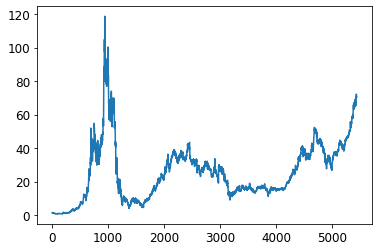

In [34]:
pdf = pd.read_csv("https://drive.google.com/uc?id=1X4-nW8phAY6H5FrPhEembOyJ8zmIG1Cz")
pdf['Close'].plot()

Following funcitons are used for building the series

In [35]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [36]:
def windowed_dataset_test(series, window_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1][np.newaxis], window[-1][np.newaxis]))
    return dataset

In [37]:
series = pdf['Close']
split_time = 4000
x_train = series[:split_time]
x_valid = series[split_time:]

In [38]:
train_set = windowed_dataset(x_train, window_size=100, batch_size=128, shuffle_buffer=128)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.Adam(lr=1e-2)
model.compile(loss=tf.keras.losses.MAE,
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=20)

Epoch 1/20
31/31 [==============================] - 3s 77ms/step - loss: 17.0276 - mae: 17.0276
Epoch 2/20
31/31 [==============================] - 2s 75ms/step - loss: 11.6604 - mae: 11.6604
Epoch 3/20
31/31 [==============================] - 2s 76ms/step - loss: 10.1335 - mae: 10.1335
Epoch 4/20
31/31 [==============================] - 2s 75ms/step - loss: 8.0623 - mae: 8.0623
Epoch 5/20
31/31 [==============================] - 2s 74ms/step - loss: 7.6967 - mae: 7.6967
Epoch 6/20
31/31 [==============================] - 2s 73ms/step - loss: 4.9309 - mae: 4.9309
Epoch 7/20
31/31 [==============================] - 2s 77ms/step - loss: 4.3378 - mae: 4.3378
Epoch 8/20
31/31 [==============================] - 2s 76ms/step - loss: 4.3099 - mae: 4.3099
Epoch 9/20
31/31 [==============================] - 2s 74ms/step - loss: 3.8923 - mae: 3.8923
Epoch 10/20
31/31 [==============================] - 2s 76ms/step - loss: 4.1403 - mae: 4.1403
Epoch 11/20
31/31 [==============================] - 

In [39]:
test_set = windowed_dataset_test(x_valid, window_size=100)
y_test = model.predict(test_set)

In [40]:
actual_y = []
for x,y in test_set:
    actual_y.append(y.numpy())
actual_y = np.array(actual_y)

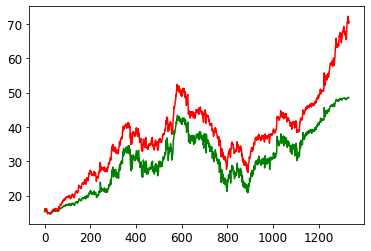

In [41]:
import matplotlib.pyplot as plt

plt.plot(y_test[:,0], 'g')
plt.plot(np.array(actual_y), 'r')


### Exercise 1

Please do the similar experiment with `aard.us.txt`

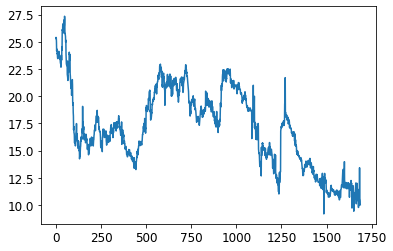

In [42]:
pdf_aard = pd.read_csv("https://drive.google.com/uc?id=1hTc4qW8aCTCNY35ksGbXTdSMe7djB2FD")
pdf_aard['Close'].plot()


In [43]:
### Your Response here 

In [44]:
### Your Response here 

In [45]:
### Your Response here 

In [46]:
### Your Response here 

In [47]:
### Your Response here 

In [48]:
### Your Response here 

In [49]:
### Your Response here 

In [50]:
### Your Response here 

In [51]:
### Your Response here 

### Exercise 2

Try Deeper RNN network and check the training loss and plot predictions versus actual  


In [52]:
### Your Response here 

In [53]:
### Your Response here 

In [54]:
### Your Response here 

### Exercise 3

Try LSTM and GRU network and check the training loss and plot predictions versus actual  


In [55]:
### Your Response here 

In [56]:
### Your Response here 

In [57]:
### Your Response here 

In [58]:
### Your Response here 

# References 

- [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition (Chapter 15)](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)

- [Deep Learning book (Chapter 10)](http://www.deeplearningbook.org/contents/rnn.html#pf7)

# Additional Resources

- Understanding LSTMs
    - https://colah.github.io/posts/2015-08-Understanding-LSTMs/
- Recurrent Neural Networks w/ TF:
    - https://www.tensorflow.org/tutorials/sequences/recurrent
    
- Keras conv networks:
    - https://keras.io/layers/recurrent/
    - https://keras.io/applications/
    
- Deep Learning book
    - Ian Goodfellow and Yoshua Bengio and Aaron Courville
    - https://www.deeplearningbook.org/contents/rnn.html
    
- Deep Learning with Python 
    - [Understanding Recurrent Neural Networks](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.2-understanding-recurrent-neural-networks.ipynb)

- [Understanding LSTM](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

- [Stock Prediction Example](https://github.com/DarkKnight1991/Stock-Price-Prediction)
- [Classical Piano Example](https://github.com/Skuldur/Classical-Piano-Composer)
